## Feature Engineering 1

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import boxcox
from scipy.stats.mstats import winsorize
from scipy.stats import jarque_bera
from scipy.stats import normaltest
from sqlalchemy import create_engine
import warnings

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

In [5]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'studentsperformance'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

students_df = pd.read_sql_query('select * from studentsperformance',con=engine)

engine.dispose()

In [6]:
students_df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [9]:
students_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
gender                         1000 non-null object
race/ethnicity                 1000 non-null object
parental level of education    1000 non-null object
lunch                          1000 non-null object
test preparation course        1000 non-null object
math score                     1000 non-null int64
reading score                  1000 non-null int64
writing score                  1000 non-null int64
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


from the above result of our initial data exploration phase, we can understand that there are no missing values.and now lets see if we have outliers in the score variables using boxplot. 

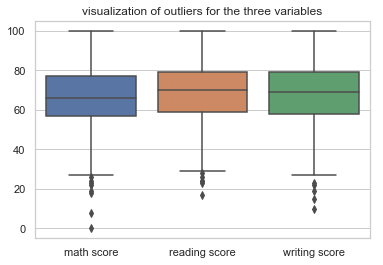

In [40]:
sns.boxplot(data = students_df[['math score', 'reading score', 'writing score']]);
plt.title('visualization of outliers for the three variables');

In [56]:
winsorized_math_scores = winsorize(students_df['math score'], (0.1, 0))
winsorized_reading_scores = winsorize(students_df['reading score'], (0.1, 0))
winsorized_writing_scores = winsorize(students_df['writing score'], (0.1, 0))

**1. Are the exam score variables normally distributed? If not, apply a Box-Cox transformation. Does anything change?**

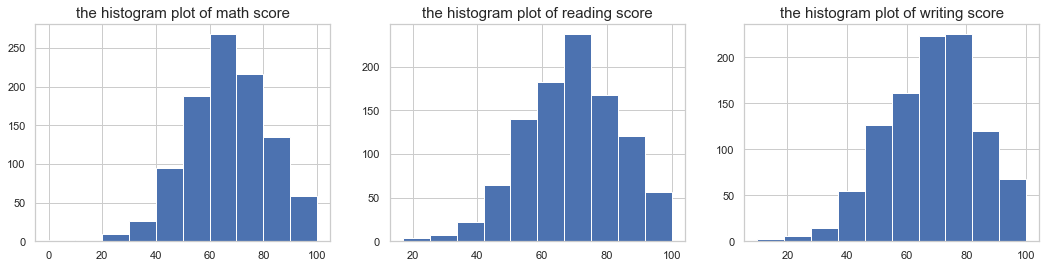

In [95]:
plt.figure(figsize = (18, 4))
for i, scores in zip(range(1,4), ['math score', 'reading score', 'writing score']):
    plt.subplot(1,3,i)
    plt.hist(students_df[scores])
    plt.title('the histogram plot of {}'.format(scores), fontsize = 15);

From the three histograms we can learn that the three winsorized variables are not normaly distributed.Therefore our next step is to normalize those variables using the scipy's boxcox function.

In [97]:
math_boxcox,_ = boxcox(students_df[students_df['math score'] > 0]['math score'])
reading_boxcox,_ = boxcox(students_df['reading score'])
writing_boxcox,_ = boxcox(students_df['writing score'])

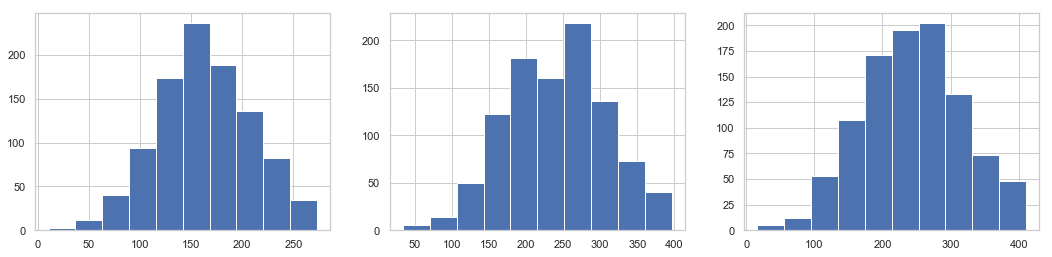

In [99]:
plt.figure(figsize = (18, 4));
for i, boxcoxed_scores in zip(range(1,4), [math_boxcox, reading_boxcox
                                           , writing_boxcox]):
    plt.subplot(1,3,i);
    plt.hist(boxcoxed_scores);

From the above plot the three variables looks more normal than the previous ones but still we need to confirm its normality using tests.

**2. Say we want to use a single variable for the exam scores as our target. For this purpose, create a new variable by taking a weighted average of the exam scores. Check whether this new variable is normally distributed. If it's not normally distributed, apply a Box-Cox transformation and check whether or not the transformed variable is normally distributed.**

In [80]:
students_df['average_scores'] = students_df[['math score', 'reading score', 'writing score']].mean(axis = 1)

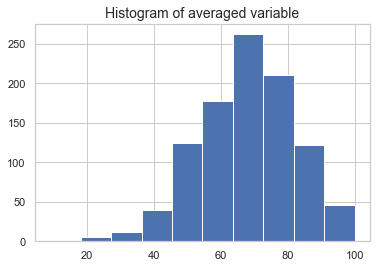

In [87]:
plt.hist(students_df['average_scores']);
plt.title('Histogram of averaged variable', fontsize = 14);

It looks quite skewed right,so to make it more normal lets apply the boxcox function.

In [83]:
average_boxcox_score,_ = boxcox(students_df['average_scores'])

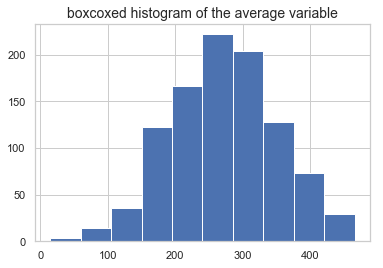

In [92]:
plt.hist(average_boxcox_score);
plt.title('boxcoxed histogram of the average variable', fontsize = 14);

Now it looks normal,but inorder to be quite sure we better apply the normality or the jarque bera tests.

In [93]:
from scipy.stats import jarque_bera
from scipy.stats import normaltest
jb_stats = jarque_bera(average_boxcox_score)
norm_stats = normaltest(average_boxcox_score)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))


Jarque-Bera test statistics is 2.4353987431906026 and p value is 0.29591016374203183
Normality test statistics is 2.779857245981238 and p value is 0.2490930835165177


Both tests confirmed that the average_boxcox_score is normaly distributed.

**3. Which variables seem related to the target variable (the newly created variable in the previous question)? If our goal is to explain the determinants of success in exams, which variables in our dataset might be useful?**


All the variables except our target variable which is the average score are categorical.Therefore one of the best visualization practices in understanding relationships between categorical and continuous variables is violinplot.The advanrtage of violinplot over other plot types is that we can see the distribution of the target variable across the categories.

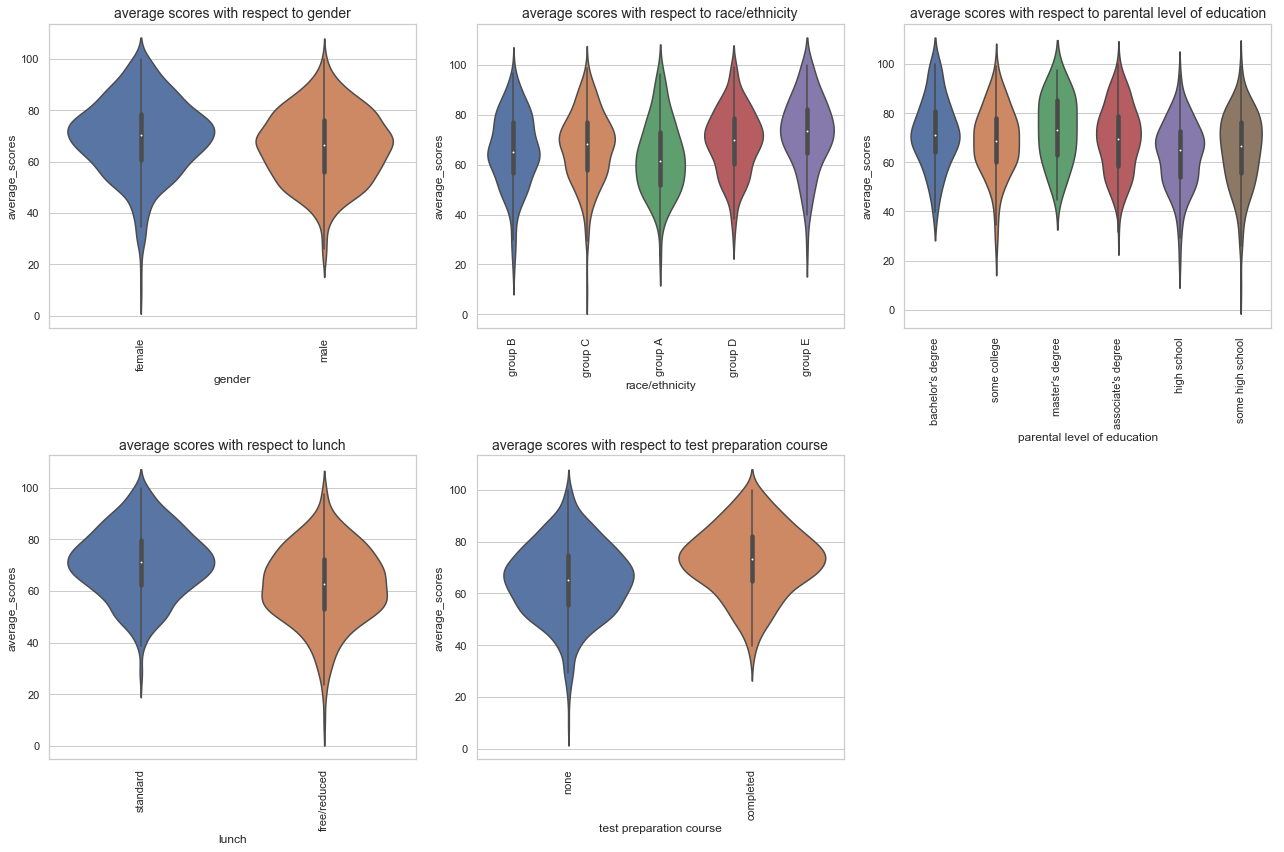

In [120]:
plt.figure(figsize = (18, 12))
for i, category in zip(range(1,6), ['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course']): 
    plt.subplot(2,3,i)
    sns.violinplot(x = students_df[category], y = students_df['average_scores'], data = students_df);
    plt.title('average scores with respect to {}'.format(category), fontsize = 14);
    plt.xticks(rotation="vertical")
    plt.tight_layout()

The above plots gives us a visual understanding about the distribution of the target variable across the features and it helps us understand their significance in affecting the target variable.the distribution in all the cases visualy looks normal and we can see for example the average of the target variable(average score) differ between men and women,and their presumably normal distribution helps as to run a ttest to compare if their mean is really different and if it is different we understand that this variable has signifficant effect on the target variable.the same applies with the two variables with two categories.Finally with the two variables with five and six categories all the procedure being the same with the previous,however when it comes to testing the variability between the means,better approach would be to be tested using ANOVA and the F-test.Logically speaking and from the visual representation all the variables except for the lunch variable seem to be useful. 